instant: record index
	- dteday : date
	- season : season (1:springer, 2:summer, 3:fall, 4:winter)
	- yr : year (0: 2011, 1:2012)
	- mnth : month ( 1 to 12)
	- hr : hour (0 to 23)
	- holiday : weather day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
	- weekday : day of the week
	- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
	+ weathersit : 
		- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
	- temp : Normalized temperature in Celsius. The values are divided to 41 (max)
	- atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
	- hum: Normalized humidity. The values are divided to 100 (max)
	- windspeed: Normalized wind speed. The values are divided to 67 (max)
	- casual: count of casual users
	- registered: count of registered users
	- cnt: count of total rental bikes including both casual and registered
    
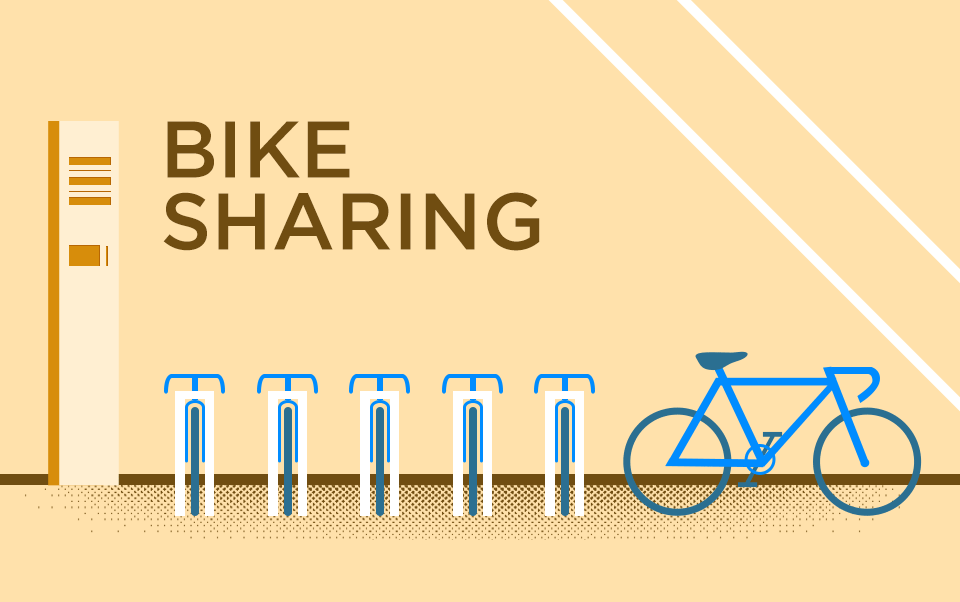

In [1]:
import pandas as pd
import pandas_profiling
import numpy as np
import missingno as msno 
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.multioutput import MultiOutputRegressor
import xgboost as xgb 
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score


In [2]:
train_data = pd.read_csv('train_bikes.csv', parse_dates=['datetime'])
train_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [3]:
test_data = pd.read_csv('test_bikes.csv', parse_dates=['datetime'])
test_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [4]:
for col in train_data.columns:   # These are columns which are not present in Train Data
    if col not in test_data.columns:
        print(col)

casual
registered
count


In [5]:
# Adding missing columns in the test data with 0's
test_data['count'] = np.NaN
test_data['casual'] = np.NaN
test_data['registered'] = np.NaN

In [6]:
df = pd.concat([ train_data, test_data ])  # Concatenating TRAIN and TEST Data together 
df.shape

/usr/local/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


(17379, 12)

In [7]:
if df.isnull().any().any()==False:
    print('There are no Null records in the dataset')
else:
    null_count = df.isnull().sum()
    print('There are Null records in following columns :')
    print(null_count[null_count > 0])

There are Null records in following columns :
casual        6493
count         6493
registered    6493
dtype: int64


In [217]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17379 entries, 0 to 6492
Data columns (total 12 columns):
atemp         17379 non-null float64
casual        10886 non-null float64
count         10886 non-null float64
datetime      17379 non-null datetime64[ns]
holiday       17379 non-null int64
humidity      17379 non-null int64
registered    10886 non-null float64
season        17379 non-null int64
temp          17379 non-null float64
weather       17379 non-null int64
windspeed     17379 non-null float64
workingday    17379 non-null int64
dtypes: datetime64[ns](1), float64(6), int64(5)
memory usage: 1.7 MB


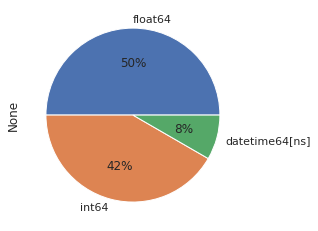

In [218]:
df.dtypes.value_counts().plot(kind='pie',autopct='%1.0f%%')   # Count of Variables as per their datatype

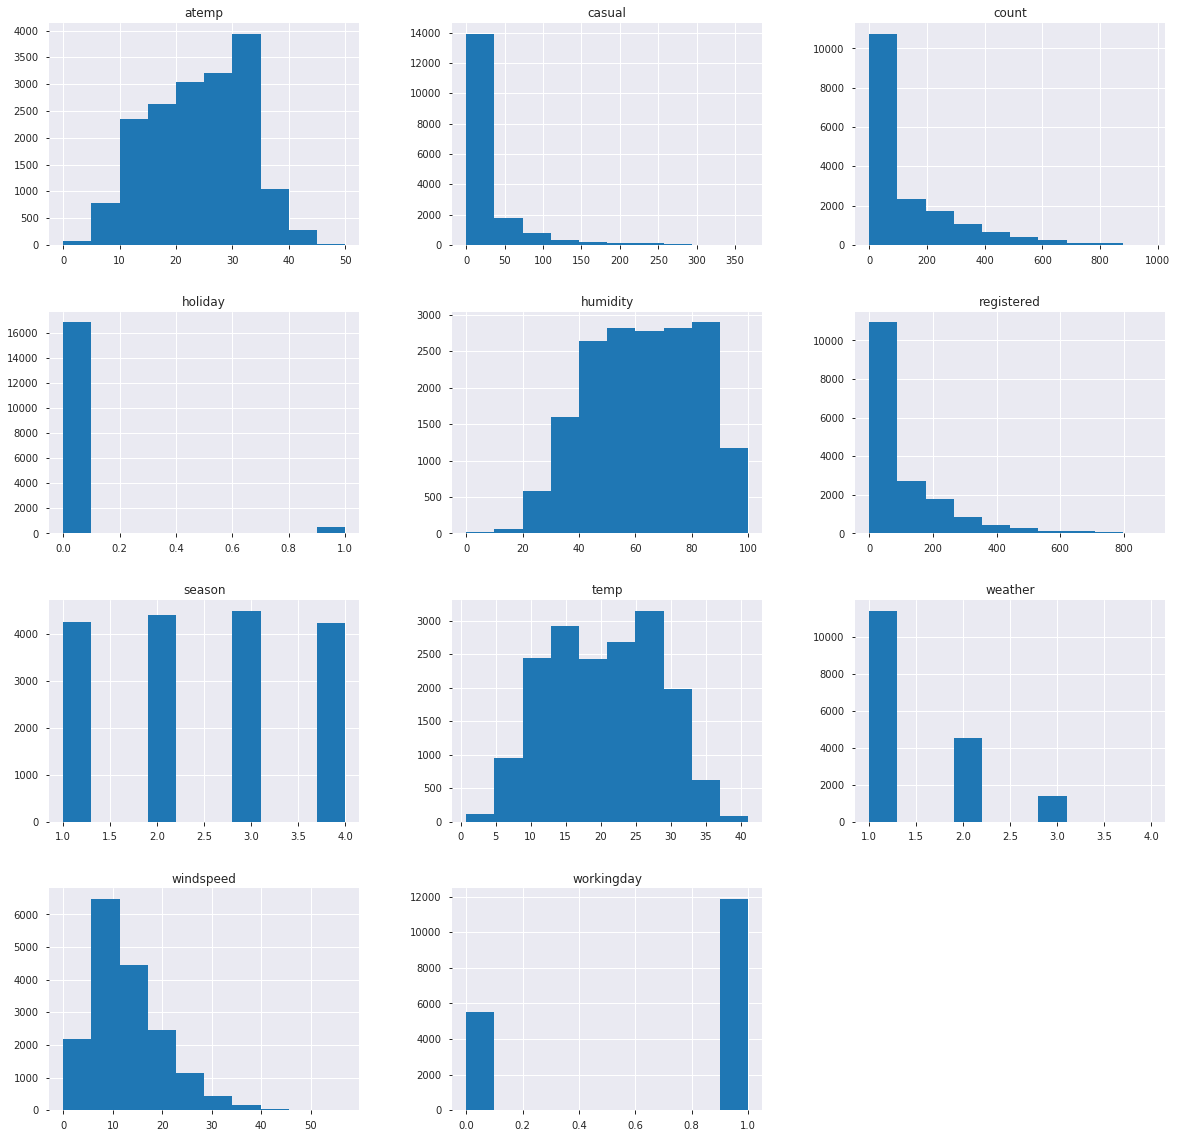

In [83]:
df.hist(figsize = (20, 20))
plt.show()

/usr/local/anaconda/lib/python3.6/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


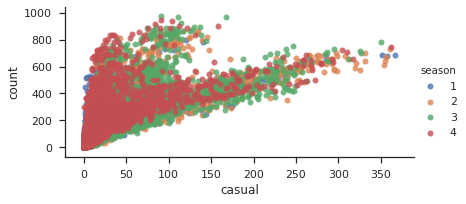

In [85]:
#df.plot.scatter(x = 'season', y = 'count', figsize=(14,8), title="Season Value Count ")
sns.set(style="ticks")
sns.lmplot("casual", "count", data=df, hue='season', fit_reg=False,  size=3, aspect=2)

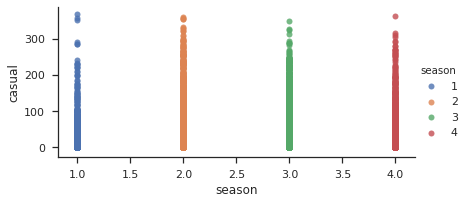

In [86]:
sns.set(style="ticks")
sns.lmplot("season", "casual", data=df, hue='season', fit_reg=False,  size=3, aspect=2)

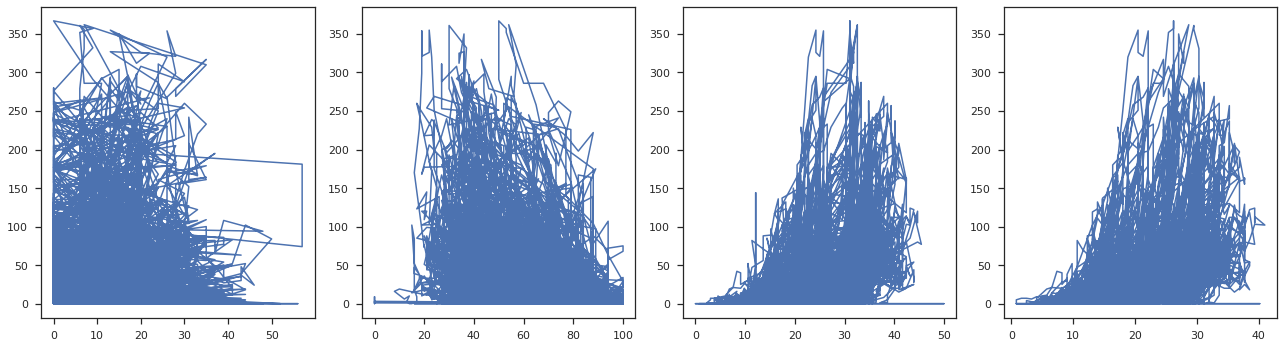

In [87]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(18, 5))
axes[0].plot(df['windspeed'], df['casual'])
axes[1].plot(df['humidity'], df['casual'])
axes[2].plot(df['atemp'], df['casual'])
axes[3].plot(df['temp'], df['casual'])
fig.tight_layout()
plt.show()

- temp and atemp shows Guassion Distribution

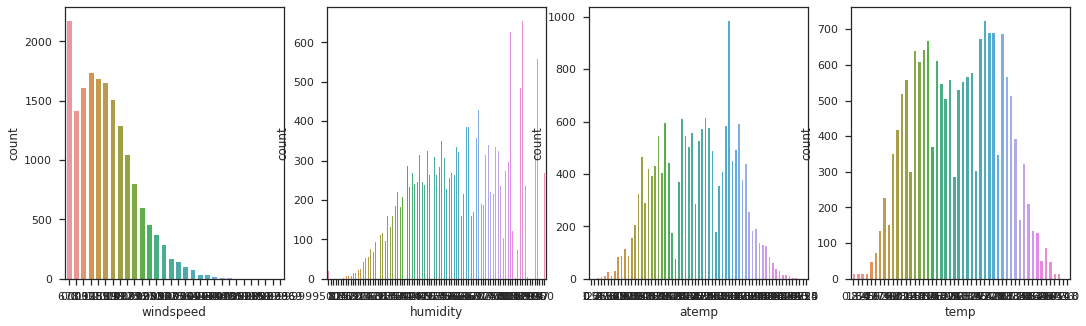

In [88]:
fig, ax =plt.subplots(1,4)
fig.set_size_inches(18, 5)
sns.countplot(df['windspeed'], ax=ax[0])
sns.countplot(df['humidity'], ax=ax[1])
sns.countplot(df['atemp'], ax=ax[2])
sns.countplot(df['temp'], ax=ax[3])
fig.show()

- Clear weather has the highest contribution 

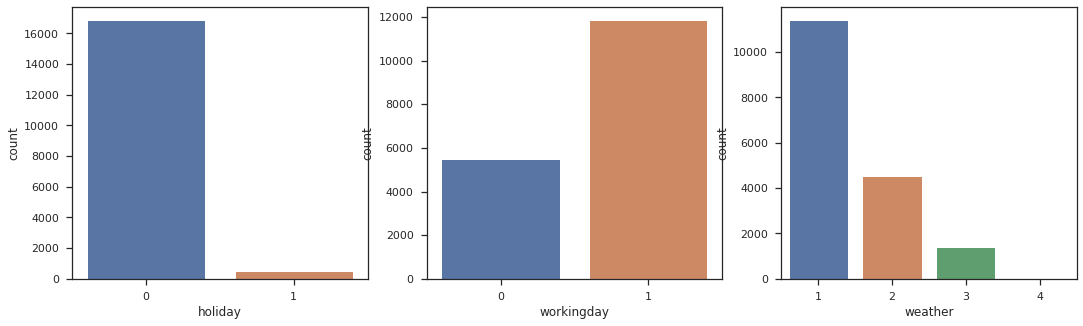

In [89]:
fig, ax =plt.subplots(1,3)
fig.set_size_inches(18, 5)
sns.countplot(df['holiday'], ax=ax[0])
sns.countplot(df['workingday'], ax=ax[1])
sns.countplot(df['weather'], ax=ax[2])
fig.show()

In [91]:
def corelation_map(orig_df, target_column):
    #target_cols  = orig_df.iloc[:,9:12].columns.tolist()
    target_cols  = orig_df.iloc[:,[1,2,6]].columns.tolist()
    features = [col for col in orig_df.columns if col != target_cols]
    corelation_value = {}
    corelation_pearson = {}
    for f in features:
        if f != 'datetime' and f not in [i for i in target_cols]:
            val = orig_df[f].corr(orig_df[target_column])
            key_col = f + ' vs ' + target_column
            corelation_value[val] =  key_col 
            corelation_pearson[key_col] = pearsonr(orig_df[f],orig_df[target_column])[0]
            
    # Both the logics generate same value
    corelation_df = pd.DataFrame(corelation_value.items())
    corelation_df.columns = [f'corelation_value_{target_column}', 'comparison']
    #corelation_df_pearson = pd.DataFrame(corelation_pearson.items())
    #corelation_df_pearson.columns = ['corelation_value_pearson', 'comparison_pearson']
    #corelation_df_pearson.drop('corelation_value_pearson',axis=1,inplace=True)
    #corelation_df = pd.concat([corelation_df, corelation_df_pearson], axis=1)
    corelation_df.loc[corelation_df[f'corelation_value_{target_column}'].abs().sort_values(ascending=False).index]
    return corelation_df

In [92]:
casual_corelation_df = corelation_map(df,'casual')
registered_corelation_df = corelation_map(df,'registered')
count_corelation_df = corelation_map(df,'count')

In [93]:
corelation_df = pd.concat([casual_corelation_df, registered_corelation_df, count_corelation_df], axis=1)
corelation_df.sort_values(['corelation_value_casual', 'corelation_value_registered','corelation_value_count'], ascending=[False, False, False])

,corelation_value_casual,comparison,corelation_value_registered,comparison,corelation_value_count,comparison
4,0.324225,temp vs casual,0.197855,temp vs registered,0.245778,temp vs count
0,0.321920,atemp vs casual,0.197109,atemp vs registered,0.244577,atemp vs count
3,0.073006,season vs casual,0.113867,season vs registered,0.112696,season vs count
6,0.070569,windspeed vs casual,0.066033,windspeed vs registered,0.072500,windspeed vs count
1,0.030983,holiday vs casual,-0.014820,holiday vs registered,-0.004420,holiday vs count
5,-0.103184,weather vs casual,-0.079998,weather vs registered,-0.092310,weather vs count
7,-0.233538,workingday vs casual,0.077399,workingday vs registered,0.004930,workingday vs count
2,-0.274176,humidity vs casual,-0.207260,humidity vs registered,-0.240892,humidity vs count


- Variable atemp is highly correlated with temp.

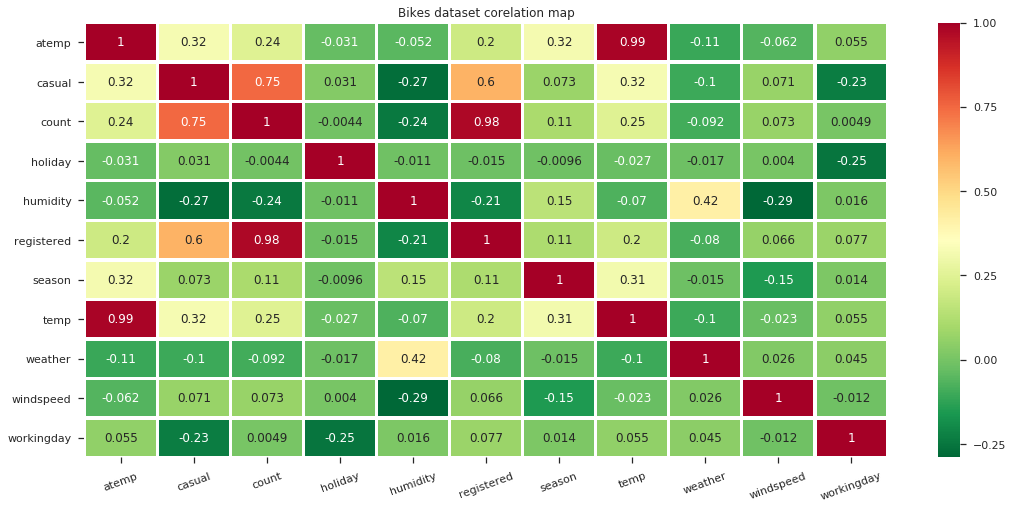

In [94]:
bikes_df = df.corr()                                  
plt.figure(figsize = (18,8))
sns.heatmap(bikes_df, annot=True, cmap='RdYlGn_r', linewidths=2.5)
plt.xticks(rotation = 20)
plt.title("Bikes dataset corelation map")
plt.show()

In [101]:
cols = [col for col in df.select_dtypes(exclude= 'object')]
cols = [col for col in cols if col not in ('datetime','casual','count','registered')]

In [102]:
# We can't take datetime as a variable here 
vif_score = [variance_inflation_factor(df[cols].values, i) for i in range(df[cols].shape[1])]
vif_data = pd.Series(vif_score, index=df[cols].columns)
vif_data = vif_data.to_frame().reset_index()
vif_data.columns = ['Variable_name', 'VIF_Score']
vif_data.sort_values('VIF_Score',ascending=False,inplace=True)
vif_data

,Variable_name,VIF_Score
0,atemp,346.359858
4,temp,317.148151
2,humidity,11.791704
5,weather,7.391092
3,season,6.797508
7,workingday,3.194661
6,windspeed,2.986547
1,holiday,1.085989


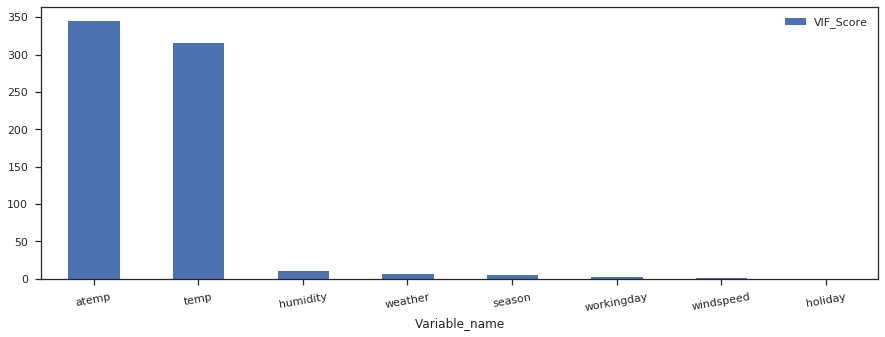

In [103]:
vif_data.plot.bar(x='Variable_name', y='VIF_Score', rot=10, figsize=(15,5))

In [104]:
df.drop(['atemp'] ,axis=1,inplace=True)  # Temp body feels

  Variable_name  VIF_Score
3          temp   7.139740
2      humidity   5.651841
5    workingday   3.327826
1     windspeed   2.798646
0        casual   1.599357
4       holiday   1.085190


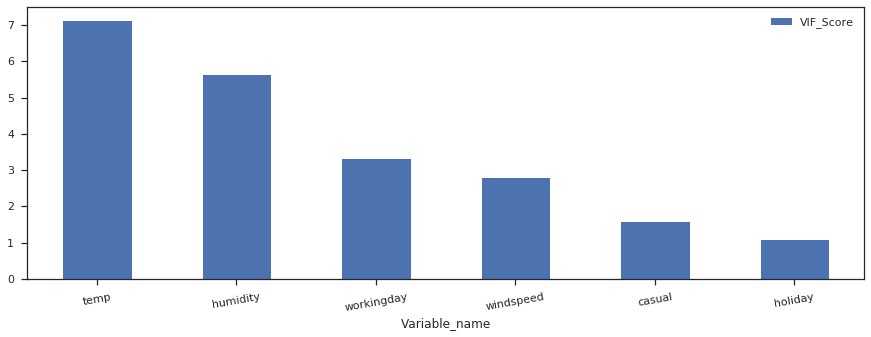

In [105]:
cols2 = ['casual','windspeed','humidity','temp','holiday','workingday']
vif_score = [variance_inflation_factor(df[cols2].values, i) for i in range(df[cols2].shape[1])]
vif_data = pd.Series(vif_score, index=df[cols2].columns)
vif_data = vif_data.to_frame().reset_index()
vif_data.columns = ['Variable_name', 'VIF_Score']
vif_data.sort_values('VIF_Score',ascending=False,inplace=True)
print(vif_data)
vif_data.plot.bar(x='Variable_name', y='VIF_Score', rot=10, figsize=(15,5))

### Feature Engineering

In [8]:
'''
Autumn (March, April, May),  season 2  clear
Winter (June, July, August), season 3 light_rain
Spring (September, October, November) season 4 heavy_rain
summer (December, January, February) season 1 cloudy
'''

replace_values = {1 : 'season_spring',
                  2 : 'season_summer',
                  3 : 'season_autumn_fall',
                  4 : 'season_winter',
                  }
df.replace({'season' : replace_values },inplace=True)

In [9]:
#combined_df.loc[ (combined_df['weather'] == 1), 'weather_name' ] = 'weather_cloudy'

replace_values = {1 : 'weather_clear',
                  2 : 'weather_cloudy',
                  3 : 'weather_moderate_rain',
                  4 : 'weather_heavy_rain',
                  }
df.replace({'weather' : replace_values },inplace=True)

In [10]:
df['year']   = df['datetime'].dt.year                               # Extratcing the Year
#df['year']  = [str(x) for x in df['datetime'].dt.year]
df['month']  = df['datetime'].dt.month                              # Extratcing the Month
df['day']    = df['datetime'].dt.day                                # Extratcing the Day
df['hour']   = df['datetime'].dt.hour                               # Extratcing the Hour
#df['DOY']   = df['datetime'].dt.strftime('%j')
df['DOY']    = [int(x.strftime('%j')) for x in df['datetime']]      # Extratcing Day of the Year
df['weekday']= df['datetime'].dt.weekday                            # Extratcing Weekday

In [11]:
replace_values = {0 : 'monday',
                  1 : 'tuesday',
                  2 : 'wednesday',
                  3 : 'thrusday',
                  4 : 'friday',
                  5 : 'saturday',
                  6 : 'sunday',
                  }
df.replace({'weekday' : replace_values },inplace=True)

In [12]:
df['weekday_cycle'] = np.where(df['weekday'].isin(['saturday','sunday']), 'weekend', 'weekday')

- Segregating data as per the demand
- Peak Hours - When people are renting bikes and going to offices
- Afternoon Hours - Not too much growth seen , it seens like a stagnant usage , as people are mostly sitting at home or offices
- Down Hours - People are relaxing at home or sleeping

In [13]:
hours_class = []
for x in df['hour']:
    if x in [7,8,17,18]:
        hours_class.append('peak_hours')
    if x in [9,10,11,12,13,14,15,16]:
        hours_class.append('afternoon_hours')
    if x in [0,1,2,3,4,5,6,19,20,21,22,23]:
        hours_class.append('down_hours')
        
df['hour_class'] = hours_class

In [14]:
replace_values = {0 : 'not_holiday',
                  1 : 'holiday'
                  }
df.replace({'holiday' : replace_values },inplace=True)

In [15]:
replace_values = {0 : 'not_working',
                  1 : 'working'
                  }
df.replace({'workingday' : replace_values },inplace=True)

In [17]:
df.head()

,atemp,casual,count,datetime,holiday,humidity,registered,season,temp,weather,windspeed,workingday,year,month,day,hour,DOY,weekday,weekday_cycle,hour_class
0,14.395,3.0,16.0,2011-01-01 00:00:00,not_holiday,81,13.0,season_spring,9.84,weather_clear,0.0,not_working,2011,1,1,0,1,saturday,weekend,down_hours
1,13.635,8.0,40.0,2011-01-01 01:00:00,not_holiday,80,32.0,season_spring,9.02,weather_clear,0.0,not_working,2011,1,1,1,1,saturday,weekend,down_hours
2,13.635,5.0,32.0,2011-01-01 02:00:00,not_holiday,80,27.0,season_spring,9.02,weather_clear,0.0,not_working,2011,1,1,2,1,saturday,weekend,down_hours
3,14.395,3.0,13.0,2011-01-01 03:00:00,not_holiday,75,10.0,season_spring,9.84,weather_clear,0.0,not_working,2011,1,1,3,1,saturday,weekend,down_hours
4,14.395,0.0,1.0,2011-01-01 04:00:00,not_holiday,75,1.0,season_spring,9.84,weather_clear,0.0,not_working,2011,1,1,4,1,saturday,weekend,down_hours


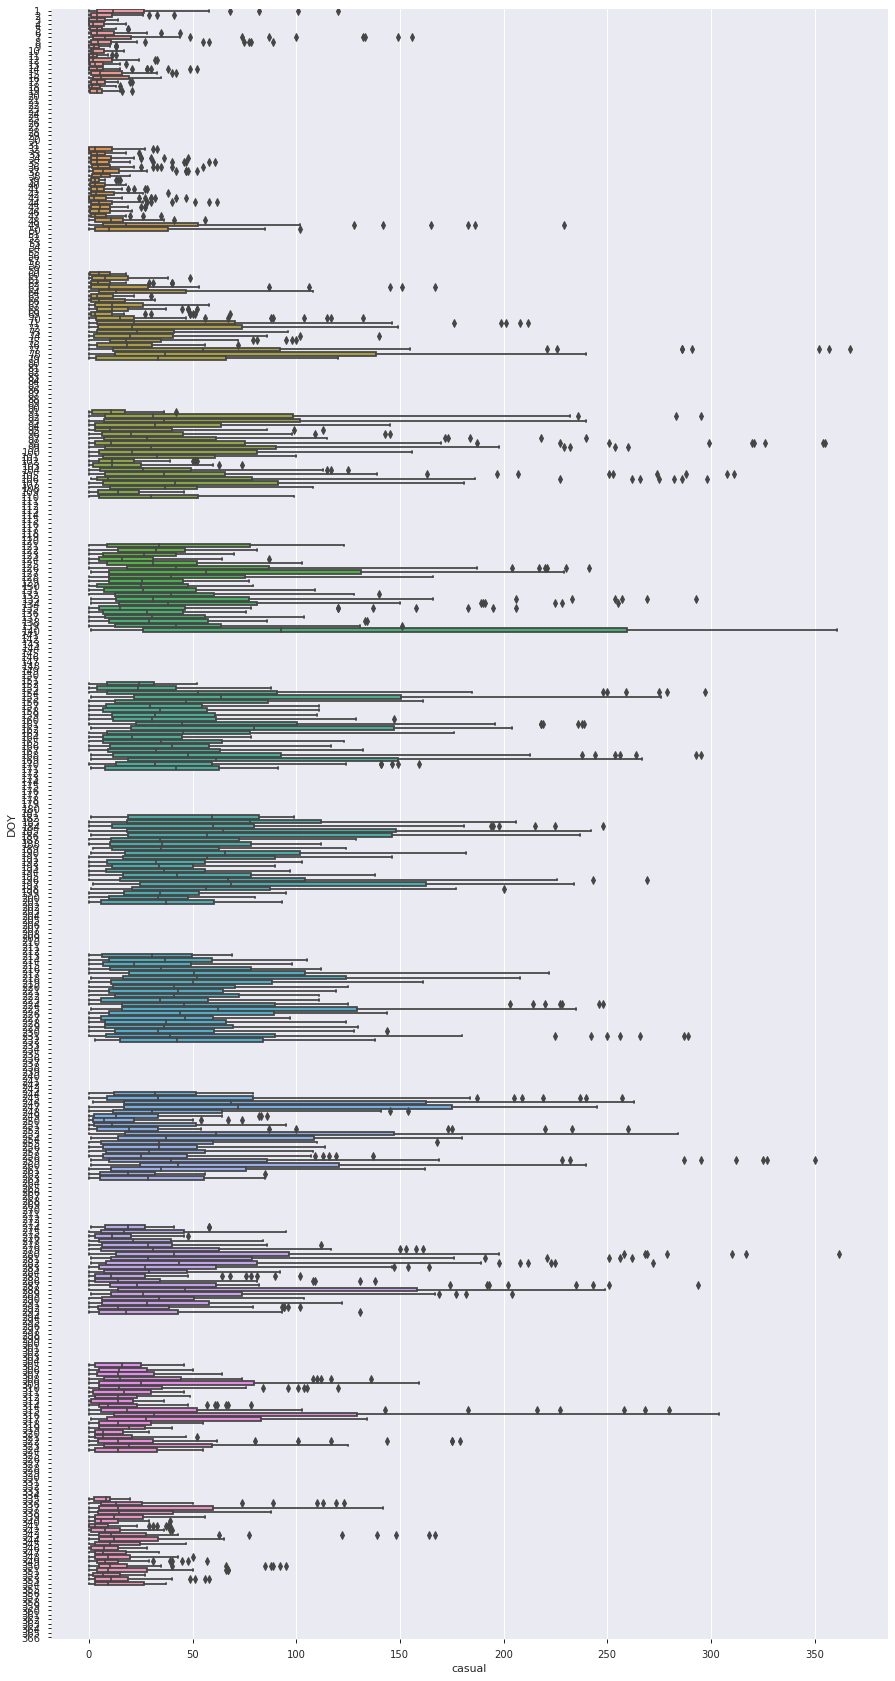

In [27]:
plt.figure(figsize = (15,30))
sns.boxplot(data=df, x='casual', y='DOY', orient='h')

-  High demand of bikes are seen during office timings.
-  As lots of Outliers can be seen, but it may be natural, Hence Box Cox Transforation , natural log can be taken

[Text(0, 0.5, 'Count'),
 Text(0.5, 0, 'hour_class'),
 Text(0.5, 1.0, 'Hour Class Analysis')]

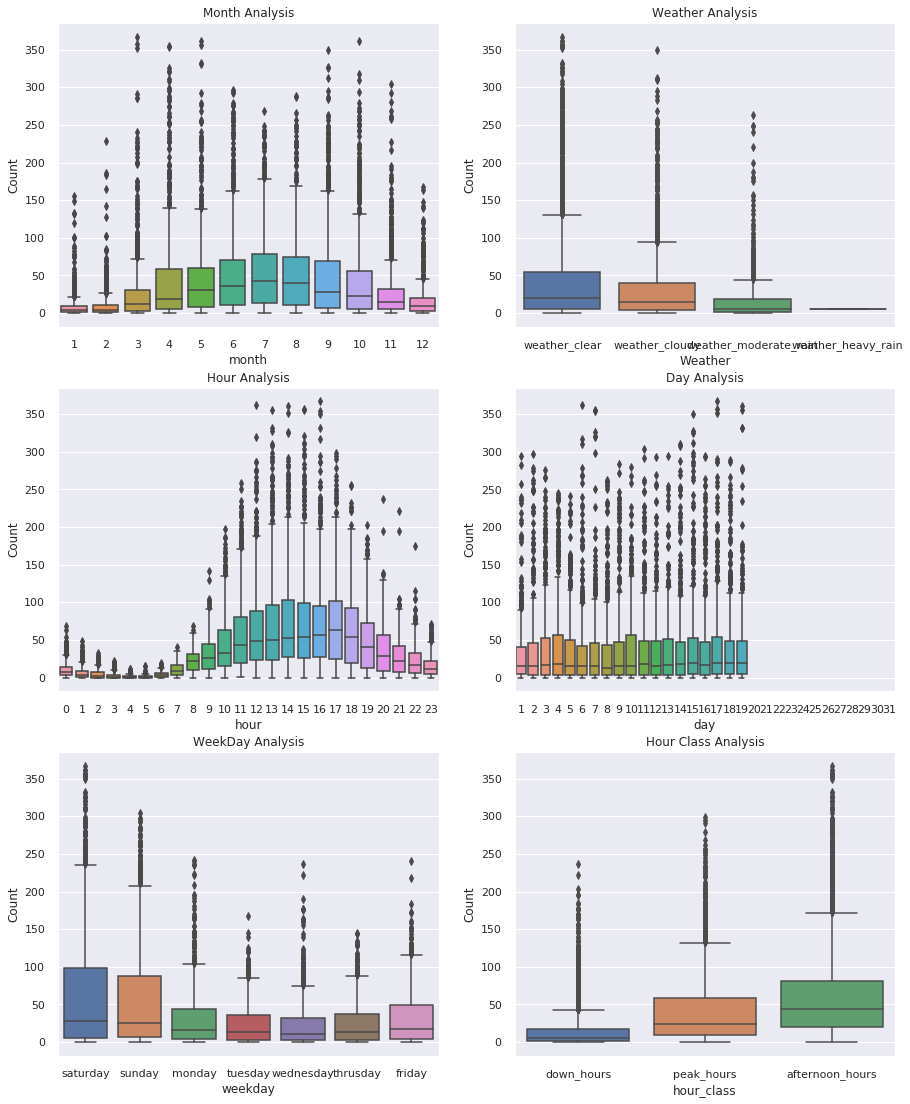

In [36]:
sns.set(font_scale=1.0)
fig,axes = plt.subplots(3,2)
fig.set_size_inches(15,19)
sns.boxplot(data=df, y='casual', x='month', orient='v', ax=axes[0][0])
sns.boxplot(data=df, y='casual', x='weather', orient='v', ax=axes[0][1])
sns.boxplot(data=df, y='casual', x='hour', orient='v', ax=axes[1][0])
sns.boxplot(data=df, y='casual', x='day', orient='v', ax=axes[1][1])
sns.boxplot(data=df, y='casual', x='weekday', orient='v', ax=axes[2][0])
sns.boxplot(data=df, y='casual', x='hour_class', orient='v', ax=axes[2][1])

axes[0][0].set(xlabel='month', ylabel='Count', title='Month Analysis')
axes[0][1].set(xlabel='Weather', ylabel='Count', title='Weather Analysis')
axes[1][0].set(xlabel='hour', ylabel='Count', title='Hour Analysis')
axes[1][1].set(xlabel='day', ylabel='Count', title='Day Analysis')
axes[2][0].set(xlabel='weekday', ylabel='Count', title='WeekDay Analysis')
axes[2][1].set(xlabel='hour_class', ylabel='Count', title='Hour Class Analysis')

In [112]:
# In which hour of the day and at both the working days whether its (0: Holiday, 1: Working), what's the count of people taking bike in both the year
# In which hour of the day , of which year , people hires more bikes 
# In which month, of which year , people hires more bikes
# working_day is 1 and holiday is 0
# unstacked.max() # Max count at working_day =1 , count is 61929. Hence we will take highest value on y-axis is 90000
# width tells the width of bars

def usage_distribution_plot(dataframe, groupby_col1, groupby_col2, year=None):  
    if year: 
        segregating_by_year = dataframe[dataframe['year'] == year]
        stack_hour_workingday = segregating_by_year.groupby([groupby_col1, groupby_col2])['count'].agg('sum')
        unstacked = stack_hour_workingday.unstack()
        return unstacked.plot(kind='bar', figsize=(15,5), width=0.9,  title="Usage in Year {0}, at every Hour of the Day, Working/Non-working".format(year))  
    else:
        stack_hour_day_byyear = dataframe.groupby([groupby_col1, groupby_col2])['count'].agg('sum')
        unstacked = stack_hour_day_byyear.unstack()
        return unstacked.plot(kind='bar', figsize=(15,5), width=0.9,  title="Usage in both Years, at every {0}".format(groupby_col1))  
  

- Figure 1 - Figure is not interpretable
- Figure 2 - Doesn't matter if it's Weekday or Weekend, people are going out and renting bikes

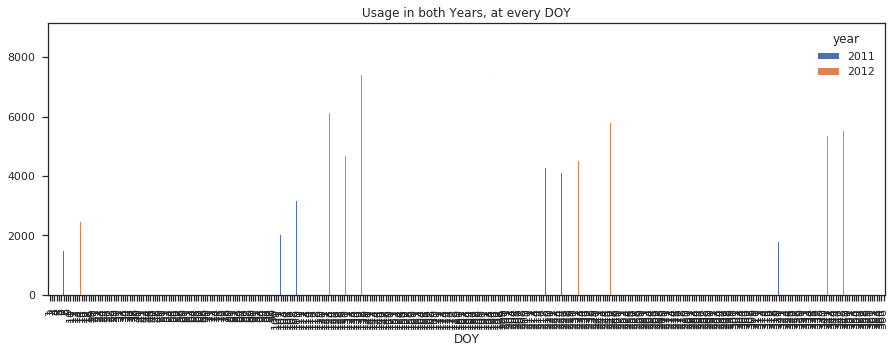

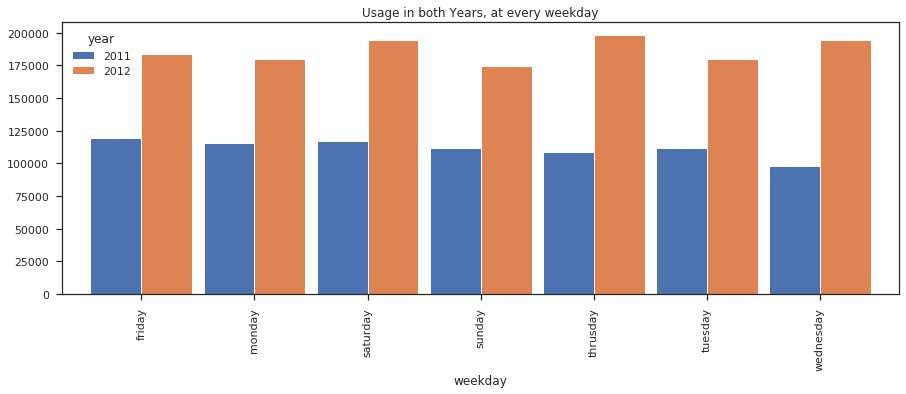

In [ ]:
usage_distribution_plot(df, 'DOY', 'year')
usage_distribution_plot(df, 'weekday', 'year')

- Figure 1 - From May till Oct, good amount of bikes have been rented out

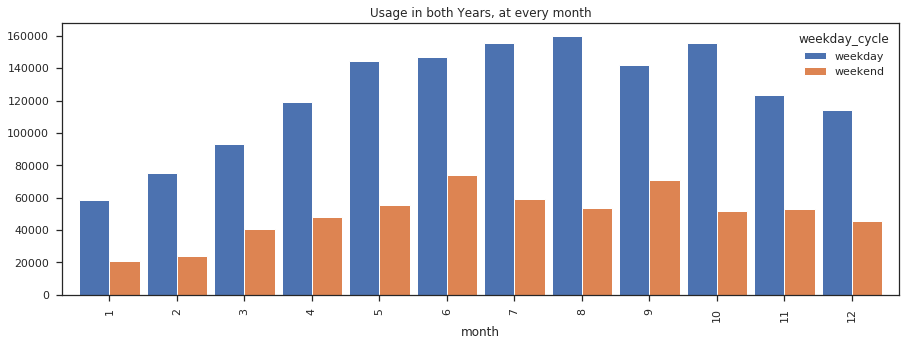

In [150]:
usage_distribution_plot(df, 'month', 'weekday_cycle')

- Figure 1 - On Weekends (Sat and Sun), people go out and they rent bikes mostly in Afternoon Hours
- Down Hours on every day remains same , as people are at home resting or sleeping
- In Peak Hours [7,8AM and 17,18 pm], same amount of bikes are rented out , apart from weekend. Because on Weekend , people prefer to rent bikes on Afternoon hours.

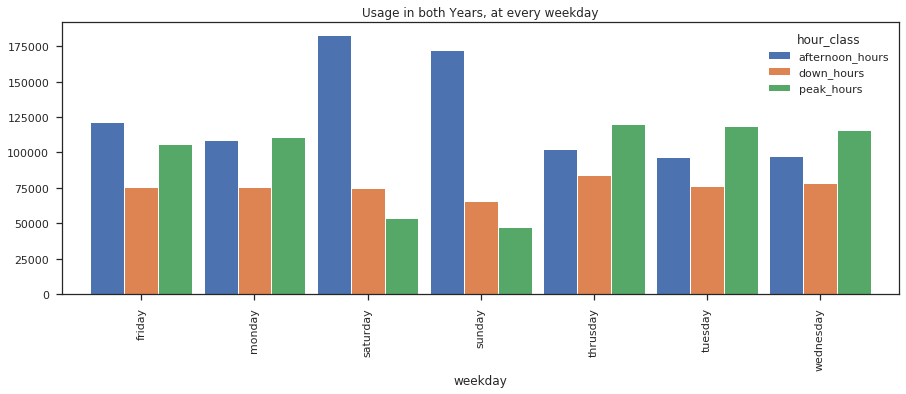

In [149]:
usage_distribution_plot(df, 'weekday', 'hour_class')

- Figure 1 - tells us that on a working day (1), peak hours are Morning 7-9am and Evening 16-20pm in YEAR 2011
- Figure 2 - Same observation is seen in YEAR 2012
- Figure 3 - Same observation is seen in Both the years 2011 and 2012
- Figure 4 - Year 2012 proved to be more fruitful year as more bikes were rented in year 2012 then 2011
- Figure 5 - Represent hour of the day for both the year, we can see in morning hours of 7-8 people are taking bikes.
   May be they are going to offices . Same trend seen between 16-20 , they are coming back to home. These are Peak      Hours
   2. Between 9 to 15 , stagnancy can be observed , its because its afternoon time 
   3. Rest of the hours of the day, people are either sleeping or resting at home 

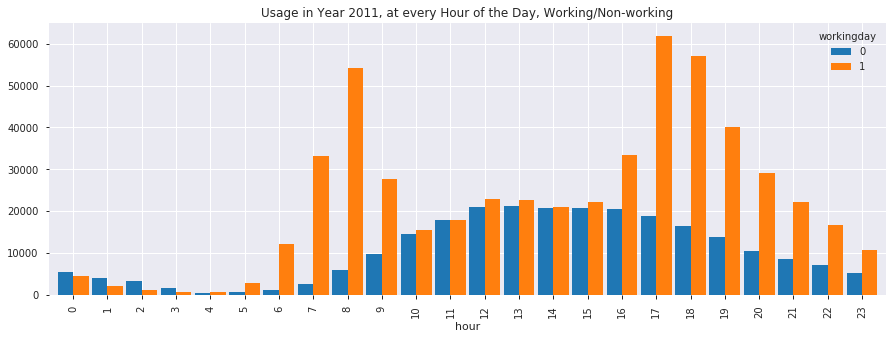

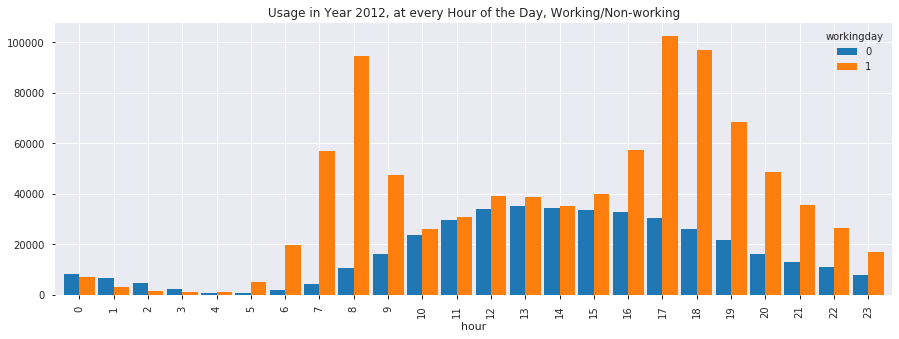

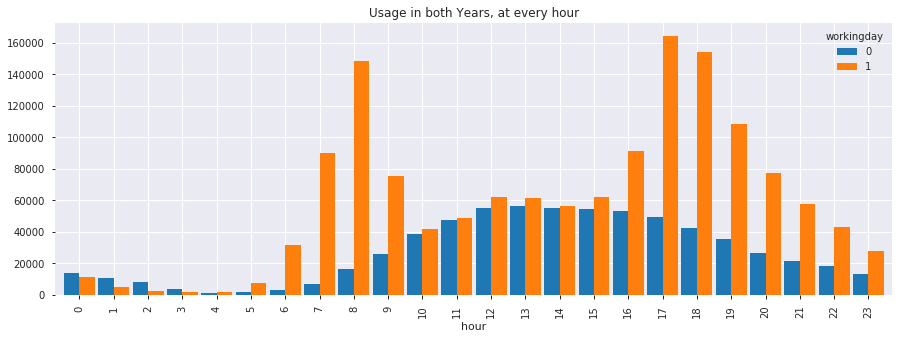

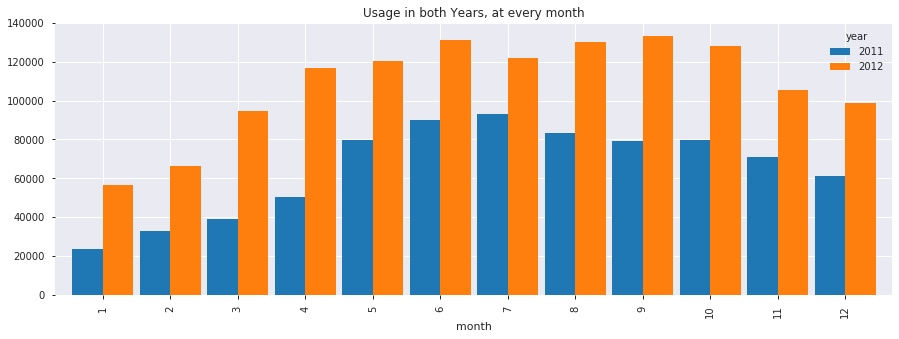

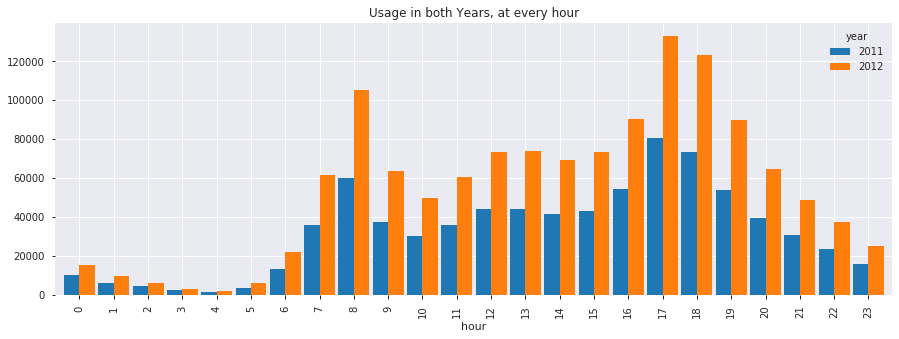

In [74]:
usage_distribution_plot(df, 'hour', 'workingday', year=2011)
usage_distribution_plot(df, 'hour', 'workingday', year=2012)
usage_distribution_plot(df, 'hour', 'workingday')  # Combining both years
usage_distribution_plot(df, 'month', 'year')
usage_distribution_plot(df, 'hour', 'year')

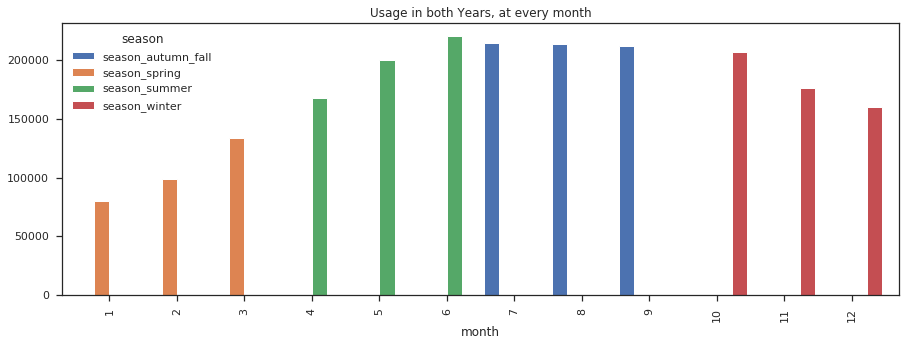

In [162]:
usage_distribution_plot(df, 'month', 'season')

#### Outlier Detection and Removal

Data Points with Outlierss : 10886
Data Points without Outlierss : 10137


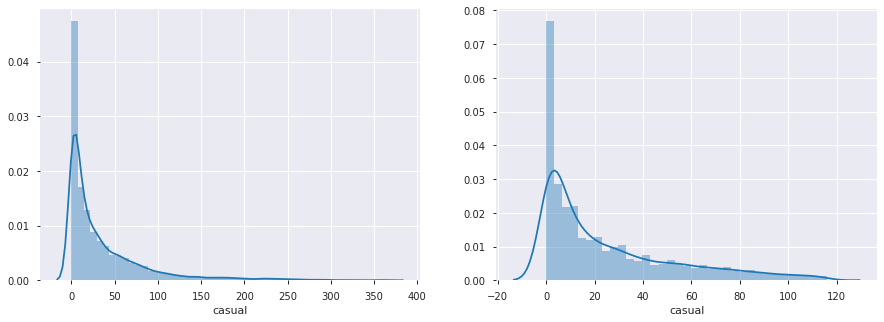

In [52]:
not_null_target = df['casual'][df['casual'].notnull()]
print(f'Data Points with Outlierss : {len(not_null_target)}')
q1 =  not_null_target.quantile(0.25)
q3 =  not_null_target.quantile(0.75)
iqr = q3-q1
lower_bound = q1 - (1.5 * iqr )
upper_bound = q3 + (1.5 * iqr )
data_without_outliers = not_null_target.loc[(not_null_target >= lower_bound) & (not_null_target <= upper_bound)]
print(f'Data Points without Outlierss : {len(data_without_outliers)}')

fig, axes = plt.subplots(1, 2)
fig.set_size_inches(15,5)

sns.distplot(not_null_target, ax=axes[0])
sns.distplot(data_without_outliers, ax=axes[1])

In [142]:
def usage_line_plot(groupby_col1):
    plt.figure(figsize = (15,6))
    df.groupby([groupby_col1]).agg("mean")['count'].plot(legend=True, grid=True)
    plt.title('{0} VS Counts'.format(groupby_col1.title()), fontsize=10)
    plt.xlabel(f'Range of {groupby_col1.title()}', fontsize=10)
    plt.ylabel('Average of the Bike Demand', fontsize=10)
    return plt.show()

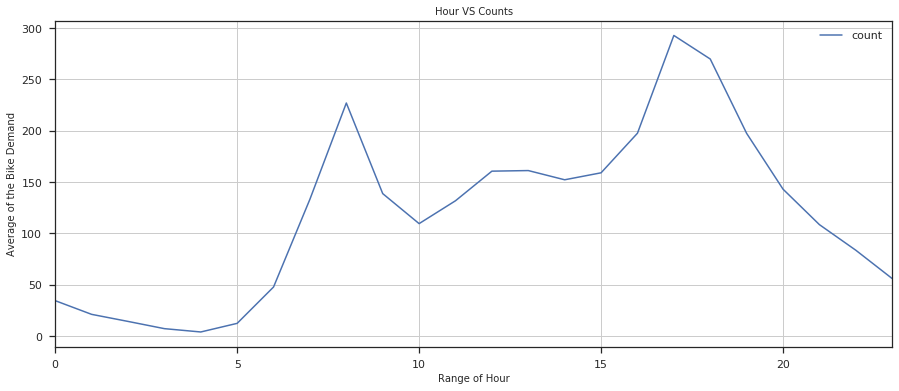

In [165]:
usage_line_plot('hour')

- This is clear indication that doesn't belong to India 
- We can see as temp rises , usage of bikes increases , which makes to assume that it may have positive correlation.
- While in India, it must show a Negative corelation

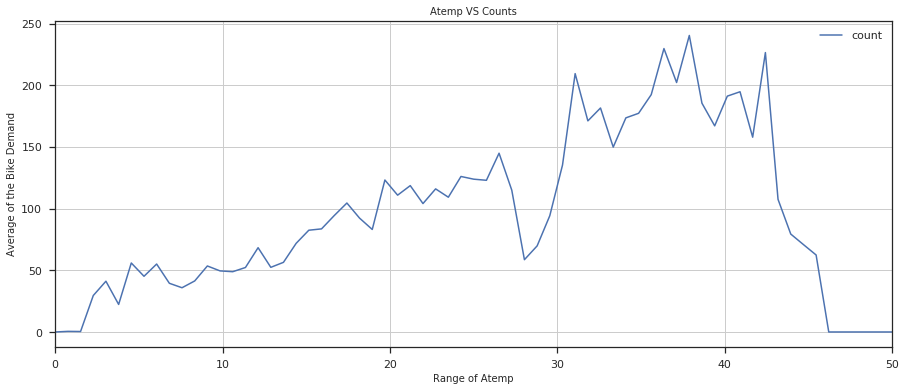

In [166]:
usage_line_plot('atemp')

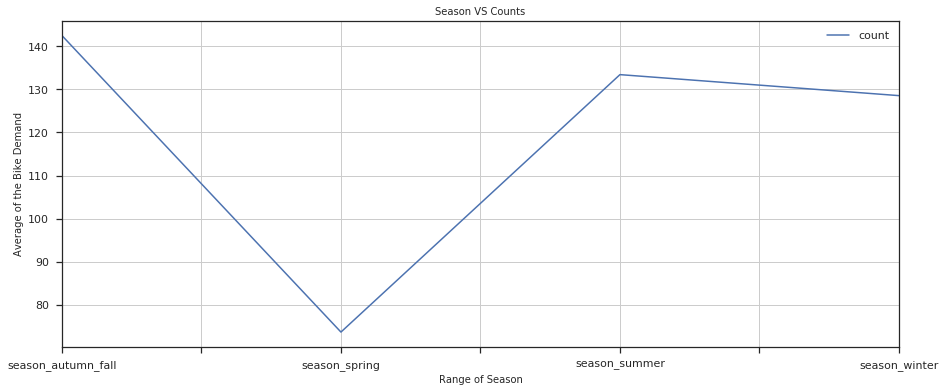

In [167]:
usage_line_plot('season')

- Demand of bikes will be lower on a rainy day as compared to a clear sunny day.

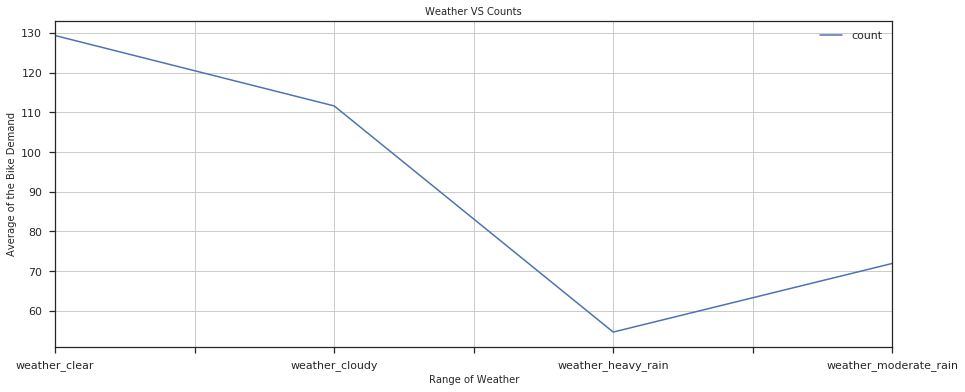

In [168]:
usage_line_plot('weather')

- Higher humidity also causes the business to fall

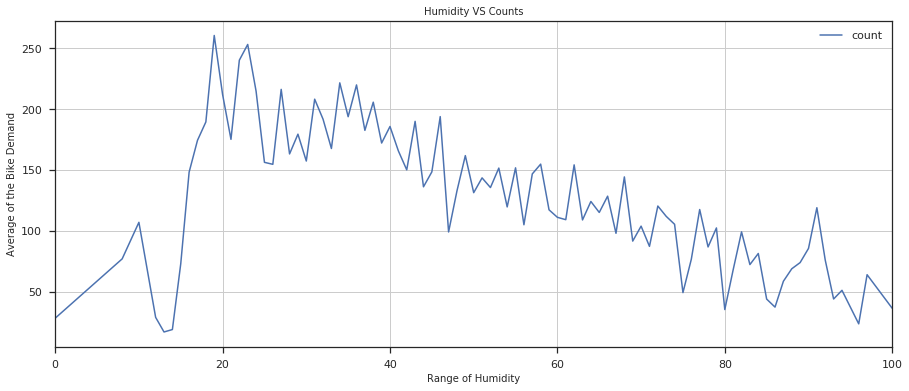

In [169]:
usage_line_plot('humidity')

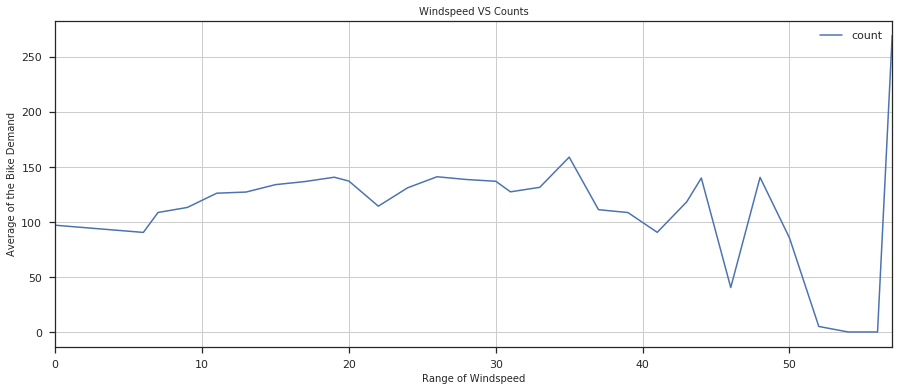

In [170]:
usage_line_plot('windspeed')

In [61]:
df.rename({'hour': 'hour_of_day', 'month': 'month_of_year'}, axis=1, inplace=True)

In [68]:
replace_values = {
                  1 : 'jan',
                  2 : 'feb',
                  3 : 'march',
                  4 : 'apr',
                  5 : 'may',
                  6 : 'june',
                  7 : 'july',
                  8 : 'august',
                  9 : 'sept',
                  10: 'oct',
                  11: 'nov',
                  12: 'dec'
                  }
df.replace({'month_of_year' : replace_values },inplace=True)

In [70]:
df_copy = df.copy()

In [71]:
df_copy.drop(['datetime','atemp','count','registered','day','DOY'], axis=1, inplace=True)

In [72]:
df_copy.to_csv('bikes_updated.csv', index=False)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import explained_variance_score
from scipy.stats import randint as sp_randint

In [2]:
df_copy = pd.read_csv('bikes_updated.csv')
print(df_copy.shape)
df_copy.head()

(17379, 14)


,casual,holiday,humidity,season,temp,weather,windspeed,workingday,year,month_of_year,hour_of_day,weekday,weekday_cycle,hour_class
0,3.0,not_holiday,81,season_spring,9.84,weather_clear,0.0,not_working,2011,jan,0,saturday,weekend,down_hours
1,8.0,not_holiday,80,season_spring,9.02,weather_clear,0.0,not_working,2011,jan,1,saturday,weekend,down_hours
2,5.0,not_holiday,80,season_spring,9.02,weather_clear,0.0,not_working,2011,jan,2,saturday,weekend,down_hours
3,3.0,not_holiday,75,season_spring,9.84,weather_clear,0.0,not_working,2011,jan,3,saturday,weekend,down_hours
4,0.0,not_holiday,75,season_spring,9.84,weather_clear,0.0,not_working,2011,jan,4,saturday,weekend,down_hours


In [3]:
def one_hot_encoder(orig_df, cat_cols):
    for each_col in cat_cols:
        dummies = pd.get_dummies(orig_df[each_col], prefix=each_col, drop_first=False)
        orig_df = pd.concat([orig_df, dummies], axis=1)
        new_df = orig_df.drop(orig_df[cat_cols],axis=1)
    return new_df

In [4]:
categorical_columns = ['holiday','season','weather','workingday','year','month_of_year','hour_of_day','weekday','weekday_cycle','hour_class']

data = one_hot_encoder(df_copy, categorical_columns)

In [5]:
scaling_columns = ['temp','humidity','windspeed']

data[scaling_columns] = StandardScaler().fit_transform(data[scaling_columns])
data.shape

(17379, 66)

In [6]:
data.columns

Index(['casual', 'humidity', 'temp', 'windspeed', 'holiday_holiday',
       'holiday_not_holiday', 'season_season_autumn_fall',
       'season_season_spring', 'season_season_summer', 'season_season_winter',
       'weather_weather_clear', 'weather_weather_cloudy',
       'weather_weather_heavy_rain', 'weather_weather_moderate_rain',
       'workingday_not_working', 'workingday_working', 'year_2011',
       'year_2012', 'month_of_year_apr', 'month_of_year_august',
       'month_of_year_dec', 'month_of_year_feb', 'month_of_year_jan',
       'month_of_year_july', 'month_of_year_june', 'month_of_year_march',
       'month_of_year_may', 'month_of_year_nov', 'month_of_year_oct',
       'month_of_year_sept', 'hour_of_day_0', 'hour_of_day_1', 'hour_of_day_2',
       'hour_of_day_3', 'hour_of_day_4', 'hour_of_day_5', 'hour_of_day_6',
       'hour_of_day_7', 'hour_of_day_8', 'hour_of_day_9', 'hour_of_day_10',
       'hour_of_day_11', 'hour_of_day_12', 'hour_of_day_13', 'hour_of_day_14',
       '

In [7]:
test_data = data[data['casual'].isnull()]
test_data.drop('casual',axis=1,inplace=True)
f'Shape of testing unseen data is : {test_data.shape}'

/usr/local/anaconda/lib/python3.6/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


'Shape of testing unseen data is : (6493, 65)'

In [8]:
train_data = data[data['casual'].notnull()]
f'Shape of training unseen data is : {train_data.shape}'

'Shape of testing unseen data is : (10886, 66)'

In [9]:
'''
X_Data = train_data.drop('casual', axis=1)
Y_Target = train_data['casual']
'''

X_Data = train_data.drop('casual', axis=1).values
Y_Target = train_data['casual'].values

print(f'Length/Data Points of Predictor columns are    : {len(X_Data)}')
print(f'Length/Data Points of Target column is         : {len(Y_Target)}')

Length/Data Points of Predictor columns are    : 10886
Length/Data Points of Target column is         : 10886


Shape of new dataset after extracting important features is  : (10886, 12)
Shape of old dataset was :                                     (10886, 65)


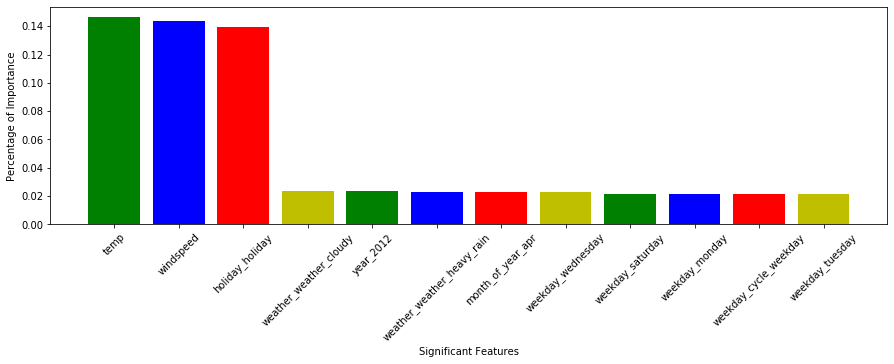

In [12]:
import sklearn
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel


classifier = sklearn.ensemble.ExtraTreesClassifier().fit(X_Data, Y_Target)
best_features = SelectFromModel(classifier, prefit=True)
X_Data_new = best_features.transform(X_Data)
print(f'Shape of new dataset after extracting important features is  : {X_Data_new.shape}')
print(f'Shape of old dataset was :                                     {X_Data.shape}')

features = X_Data_new.shape[1]
importances = classifier.feature_importances_
indices = np.argsort(importances)[::-1]

feature_imp = {}
for i in range(features):
    #print(df.columns[2+indices[i]], importances[indices[i]])
    column_name   = train_data.columns[2+indices[i]]
    feature_value = importances[indices[i]]
    feature_imp[column_name] = feature_value


plt.figure(figsize=(15,4))
plt.bar(list(feature_imp.keys()), feature_imp.values(), color='gbry')
plt.ylabel ('Percentage of Importance')
plt.xlabel ('Significant Features')
plt.xticks(rotation=45)
plt.show()

### Train Test Split Data

In [10]:
X_train, x_test, Y_train, y_test = train_test_split(X_Data, Y_Target, test_size = 0.2)

print(f'Shape of Training set is : {X_train.shape}')
print(f'Shape of Testing set is  : {x_test.shape}')

Shape of Training set is : (8708, 65)
Shape of Testing set is  : (2178, 65)


#### Defining Manual Cost Functions

In [11]:
def MSE(y_true,y_pred):
    mse = mean_squared_error(y_true, y_pred)
    return mse

def R2(y_true,y_pred): 
    r2 = r2_score(y_true, y_pred)
    return r2

### Random Forest Regressor with Random Search CV

In [12]:
param_dist = {"max_depth": [3, None],
              "max_features": sp_randint(1, X_train.shape[1]),
              "min_samples_split": sp_randint(2, 11),
              "bootstrap": [True, False],
              "n_estimators": sp_randint(100, 500)}


rf_regressor = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_regressor = rf_regressor.fit(X_train, Y_train)

random_search = RandomizedSearchCV(rf_regressor, param_distributions=param_dist,
                                   n_iter=10, cv=5, iid=False, random_state=42)
random_search.fit(X_train, Y_train)

y_pred = random_search.predict(x_test)
y_pred = [round(value) for value in y_pred]

f'Model training is done, please check the score metrices'

/usr/local/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


'Model training is done, please check the score metrices'

In [13]:
from sklearn.metrics import mean_squared_error,r2_score, mean_squared_log_error, mean_absolute_error
# MSLE can not handle negative values
# EVS - It explains th total variance that is explained by varibles that are actually present and isn't due to error variance.

print(f'Explained Variance Score          : {explained_variance_score(y_test, y_pred)}')
print(f'Root Mean Squared Error           : {np.sqrt(mean_squared_error(y_test, y_pred))}')
print(f'Mean Squared Error                : {mean_absolute_error(y_test, y_pred)}')
print(f'R^2 Coefficient of Determination  : {r2_score(y_test, y_pred)}')
print(f'RMSLE Root Mean Squared Log Error : {np.sqrt(mean_squared_log_error(y_test, y_pred))}')

Explained Variance Score          : 0.91300740352486
Root Mean Squared Error           : 14.755771154675244
Mean Squared Error                : 8.833792470156107
R^2 Coefficient of Determination  : 0.9129790608927472
RMSLE Root Mean Squared Log Error : 0.5463648080810114


In [14]:
x_test_final = pd.DataFrame(x_test,  columns = test_data.columns)
id_vals = x_test_final.index

comparison_tbl = pd.DataFrame()
comparison_tbl["ID"] = id_vals
comparison_tbl["Prediction"] = y_pred
comparison_tbl["Actual"] = y_test
comparison_tbl[['Prediction','Actual']].head()

,Prediction,Actual
0,25.0,27.0
1,3.0,0.0
2,23.0,11.0
3,62.0,66.0
4,16.0,7.0


In [18]:
results = random_search.cv_results_
for mean_score, params in zip(results["mean_test_score"], results["params"]):
    print(mean_score, params)

0.9002138163276951 {'bootstrap': True, 'max_depth': None, 'max_features': 29, 'min_samples_split': 9, 'n_estimators': 288}
0.5965883456369818 {'bootstrap': True, 'max_depth': 3, 'max_features': 58, 'min_samples_split': 4, 'n_estimators': 314}
0.5843637435133842 {'bootstrap': True, 'max_depth': 3, 'max_features': 24, 'min_samples_split': 6, 'n_estimators': 199}
0.8529730848694699 {'bootstrap': False, 'max_depth': None, 'max_features': 3, 'min_samples_split': 7, 'n_estimators': 408}
0.8976314667648442 {'bootstrap': False, 'max_depth': None, 'max_features': 44, 'min_samples_split': 7, 'n_estimators': 485}
0.9093901434475319 {'bootstrap': False, 'max_depth': None, 'max_features': 21, 'min_samples_split': 2, 'n_estimators': 413}
0.5928421109672489 {'bootstrap': False, 'max_depth': 3, 'max_features': 44, 'min_samples_split': 10, 'n_estimators': 148}
0.5893786285833352 {'bootstrap': True, 'max_depth': 3, 'max_features': 63, 'min_samples_split': 4, 'n_estimators': 463}
0.8924844198164628 {'boo

In [21]:
print(random_search.best_estimator_)
print('***'*35)
print(random_search.best_params_)

RandomForestRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=21, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=413, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)
*********************************************************************************************************
{'bootstrap': False, 'max_depth': None, 'max_features': 21, 'min_samples_split': 2, 'n_estimators': 413}


In [17]:
important_feature = random_search.best_estimator_.feature_importances_
variable_names = list(x_test_final.columns)

feature_importance= sorted(zip(important_feature, variable_names), reverse=True) # Sorting by score
df_importance = pd.DataFrame(feature_importance, columns=['Importance', 'Variable_Name'])
df_importance.head()

,Importance,Variable_Name
0,0.209756,temp
1,0.105324,hour_class_down_hours
2,0.098221,humidity
3,0.079801,hour_class_afternoon_hours
4,0.057064,workingday_working


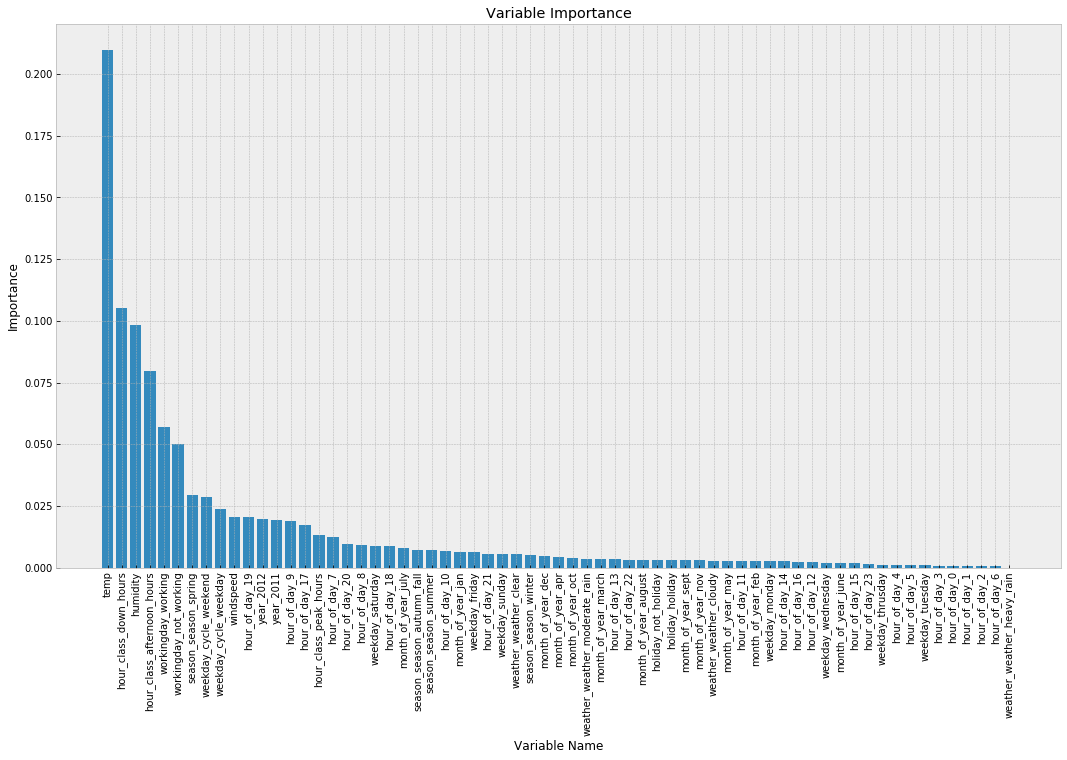

In [19]:
importance = list(df_importance['Importance'])
variable    = list(df_importance['Variable_Name'])

plt.style.use('bmh')
x_range = list(range(len(feature_importance)))
plt.figure(figsize=(18,10))
plt.bar(x_range, importance, orientation = 'vertical')
plt.xticks(x_range, variable, rotation='vertical')
plt.ylabel('Importance'); plt.xlabel('Variable Name'); plt.title('Variable Importance');

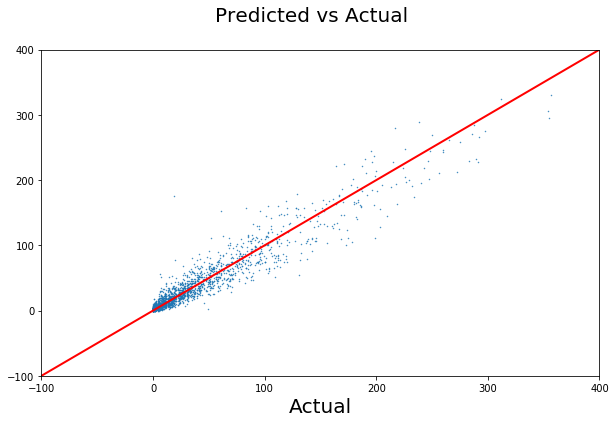

In [19]:
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred, s=0.2)
plt.xlim(-100,400)
plt.ylim(-100,400)
plt.plot([-100,400],[-100,400],color='r',linestyle= '-', linewidth=2)
plt.suptitle('Predicted vs Actual', fontsize=20)
plt.xlabel('Predicted',fontsize=20)
plt.ylabel('Actual',fontsize=20)
plt.show()